# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import statistics as st
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import cv2
import random
from tqdm import tqdm, trange
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

Our dataset is composed of a training set of 39209 pictures and a test set of 12630 pictures. But, a problem that we can deal with is that all picture don't have the same size. They're all 3-dimension arrays, but some are 27 by 27 by 3, some 28 by 28 by 3,... and it can be a problem when we want to train some models on it.

As we previously saw, to compute our K-NN algorithm, we need pictures to be 1-dimension vectors, so we need to flatten it. But, as I'm working on Google Colab, my variables environment is reloaded each time I start a session, so it would mean that I need to flatten ALL my pictures each time. The problem is that it takes around 3h30 to flatten all my train set, and almost 1h30 for the test set. It's obviously not possible to wait 5h each time before I need to work on my code.

A solution I found was to create new datasets that I would just have to load each time I start a new session. This is possible with the functions **np.save** and **np.load**, and this what I used. There is the procedure I used to create two new flattened datasets that I just load each time, so I just need to use this procedure one time instead of each time I want t work on my code : (I commented it in order not to run it when I run all my code. This is the procedure used for the train set, but it was exactly the same for the test set)



In [7]:
def image_to_feature_vector(image, size=(32,32)):
	return cv2.resize(image, size).flatten()

In [ ]:
#im = cv2.imread(df_train.iloc[0,7])
#df_im=image_to_feature_vector(im)
#for i in range(1,len(df_train)):
  #im = cv2.imread(df_train.iloc[i,7]) ## read the image path
  #im=image_to_feature_vector(im)
  #df_im=np.append(df_im.reshape(i,3072),im.reshape(1,3072),axis=0)

#np.save("/content/drive/MyDrive/Deep Learning/df_im",df_im)

#im = cv2.imread(df_train.iloc[0,7])
#df_im_test=image_to_feature_vector(im)
#for i in range(1,len(df_test)):
  #im = cv2.imread(df_test.iloc[i,7]) ## read the image path
  #im=image_to_feature_vector(im)
  #df_im_test=np.append(df_im_test.reshape(i,3072),im.reshape(1,3072),axis=0)

#np.save("/content/drive/MyDrive/Deep Learning/df_im_test",df_im_test)

In the same time, and for my further Deep Learning model, I'll need to have same size pictures (32 by 32 by 3). So, I used a similar procedure to obtain a new set of reshaped arrays pictures in order to keep same size inputs in my Deep Learning model : 

In [ ]:
#df_raw_train=cv2.resize(cv2.imread(df_train.iloc[0,7]),(32,32))
#for i in trange(1,len(df_train)):
  #im=cv2.resize(cv2.imread(df_train.iloc[i,7]),(32,32))
  #df_raw_train=np.append(df_raw_train.reshape(i,32,32,3),im.reshape(1,32,32,3),axis=0)

#np.save("/content/drive/MyDrive/Deep Learning/raw_train_2",df_raw_train)

#df_raw_test=cv2.resize(cv2.imread(df_test.iloc[0,7]),(32,32))
#for i in trange(1,len(df_test)):
  #im=cv2.resize(cv2.imread(df_test.iloc[i,7]),(32,32))
  #df_raw_test=np.append(df_raw_test.reshape(i,32,32,3),im.reshape(1,32,32,3),axis=0)

#np.save("/content/drive/MyDrive/Deep Learning/raw_test_2",df_raw_test)

Then, I'll just have to use the **np.load** function to get my new dataset and work on it.

Also, for all our predictions, we will use the same procedure to estimate our accuracy : 

In [ ]:
#y_pred=model.predict(x_test)
#y_test=pd.DataFrame(y_test,columns=['ClassId'])
#y_test['ClassId']=y_test['ClassId'].astype(int)
#y_pred=pd.DataFrame(y_pred,columns=['ClassId'])
#y_pred['ClassId']=y_pred['ClassId'].astype(int)
#abs(y_pred-y_test).value_counts()/len(y_test)

This compare the difference between our predictions and the real classes. The more we have a 0 percentage, the better our prediction model is. 

# K-NN model

In [5]:
df_train=pd.read_csv("/content/drive/MyDrive/Deep Learning/data/Train.csv")
df_train['Path']=df_train.Path.apply(lambda x: "/content/drive/MyDrive/Deep Learning/data/"+x) ## change and normalize path
df_train['ClassId']=df_train.ClassId.astype(str)

df_test=pd.read_csv("/content/drive/MyDrive/Deep Learning/data/Test.csv")
df_test['Path']=df_test.Path.apply(lambda x: "/content/drive/MyDrive/Deep Learning/data/"+x) ## change and normalize path
df_test['ClassId']=df_test.ClassId.astype(str)

In [6]:
def weighted_knn_classification(x_test, x_train, y_train,minlen,k=10):
  y_pred=pd.DataFrame(columns=["ClassId"])
  for i in x_test.index.to_list():
    dist=np.linalg.norm(x_train-x_test.loc[i],axis=1)
    indexs=dist.argsort()[:k]
    dist=np.sort(dist)[:k]
    weights=1./dist
    a=np.bincount(y_train.iloc[indexs],weights=weights,minlength=minlen)
    class_pred=a.argsort()[-1]
    y_pred.loc[i]=class_pred
  return y_pred

In [76]:
x_train=np.load("/content/drive/MyDrive/Deep Learning/df_im.npy")

In [77]:
x_test=np.load("/content/drive/MyDrive/Deep Learning/df_im_test.npy")

In [11]:
y_train=df_train['ClassId']

In [12]:
y_test=df_test['ClassId']

In [13]:
assert x_train.shape==(39209, 3072)
assert x_test.shape==(12630, 3072)
assert y_train.shape==(39209,)
assert y_test.shape==(12630,)

In [14]:
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)

In [15]:
y_test=pd.DataFrame(y_test,columns=["ClassId"])
y_test=y_test.astype(int)

In [16]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [17]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [18]:
y_pred=knn.predict(x_test)
y_pred=pd.DataFrame(y_pred,columns=['ClassId'])
y_pred=y_pred.astype(int)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.27      0.23        60
           1       0.32      0.33      0.32       720
           2       0.29      0.26      0.27       750
           3       0.12      0.16      0.14       450
           4       0.33      0.34      0.34       660
           5       0.18      0.31      0.23       630
           6       0.49      0.33      0.39       150
           7       0.23      0.34      0.27       450
           8       0.26      0.26      0.26       450
           9       0.53      0.24      0.33       480
          10       0.45      0.59      0.51       660
          11       0.48      0.26      0.34       420
          12       0.67      0.53      0.59       690
          13       0.78      0.88      0.83       720
          14       0.89      0.27      0.42       270
          15       0.37      0.28      0.32       210
          16       0.46      0.65      0.54       150
          17       0.93    

In [20]:
y_pred=pd.DataFrame(y_pred,columns=["ClassId"])
y_pred=y_pred.astype(int)
(abs(y_pred-y_test).value_counts()/len(y_pred))

ClassId
0          0.378385
1          0.088519
2          0.070230
3          0.066746
4          0.059699
5          0.040618
6          0.040063
7          0.028741
8          0.019794
10         0.018527
13         0.016390
11         0.016390
9          0.015914
14         0.013302
15         0.010610
26         0.009976
20         0.009343
12         0.008709
22         0.006888
23         0.006651
36         0.006413
17         0.006176
16         0.005859
27         0.005622
18         0.005226
28         0.004513
24         0.004355
25         0.004355
29         0.004196
19         0.003959
30         0.003563
35         0.003563
34         0.003405
21         0.003246
31         0.002692
37         0.002692
33         0.001742
38         0.001188
32         0.001108
40         0.000396
42         0.000158
39         0.000079
dtype: float64

This computes the difference of real class and the estimated class. We have around 37% of 0, what means that 37% of data is properly estimated.

In [21]:
acc=[]
y_test=pd.DataFrame(y_test,columns=["ClassId"])
y_test=y_test.astype(int)

for neigh in trange(2,2000,200):
  knn = KNeighborsClassifier(n_neighbors=neigh)
  knn.fit(x_train, y_train)
  y_pred=knn.predict(x_test)
  y_pred=pd.DataFrame(y_pred,columns=["ClassId"])
  y_pred=y_pred.astype(int)
  acc.append((abs(y_pred-y_test).value_counts()/len(y_pred))[0])

100%|██████████| 10/10 [16:56<00:00, 101.61s/it]


Text(0.5, 1.0, 'Evolution of accuracy depending on neighbours number')

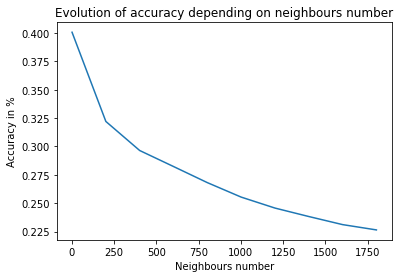

In [22]:
a=range(2,2000,200)
plt.plot(a,acc)
plt.xlabel('Neighbours number')
plt.ylabel('Accuracy in %')
plt.title('Evolution of accuracy depending on neighbours number')

# PCA

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)

In [63]:
x_train_pca = pca.fit_transform(x_train)

In [85]:
x_train_pca[0,0:5,]

array([-19.20876989,   3.70651435,   5.04274275,  -3.51974612,
         3.96467569])

In [84]:
x_train[0,0:5]

array([56, 51, 46, 56, 51], dtype=uint8)

In [64]:
sum(pca.explained_variance_ratio_)

0.9190610143503759

In [65]:
x_test_pca=pca.fit_transform(x_test)

In [86]:
x_test_pca[0,0:5]

array([ 21.68520383,  20.28246124, -12.56508012,  -2.37343284,
       -11.49861409])

In [87]:
x_test[0,0:5]

array([174, 139, 116, 171, 137], dtype=uint8)

In [79]:
knn = KNeighborsClassifier(n_neighbors=2)

In [80]:
knn.fit(x_train_pca, y_train)

KNeighborsClassifier(n_neighbors=2)

In [88]:
y_pred_pca=knn.predict(x_test_pca)

In [90]:
y_pred_pca=pd.DataFrame(y_pred_pca,columns=['ClassId'])
y_pred_pca['ClassId']=y_pred_pca['ClassId'].astype(int)
abs(y_pred_pca-y_test).value_counts()/len(y_test)

ClassId
1          0.085669
0          0.075218
3          0.072130
2          0.069834
6          0.052019
5          0.051306
4          0.050673
8          0.039351
11         0.033096
10         0.031433
13         0.029295
12         0.027712
9          0.026287
7          0.026207
20         0.024386
25         0.023832
16         0.020823
14         0.020111
21         0.019873
15         0.018606
23         0.017577
18         0.017181
26         0.016548
24         0.015677
17         0.014727
19         0.014410
28         0.014410
22         0.014093
27         0.012589
31         0.010530
30         0.007838
29         0.007363
35         0.007284
34         0.006334
36         0.006334
32         0.005384
37         0.004592
33         0.003563
40         0.003009
38         0.001425
39         0.001029
41         0.000238
dtype: float64

In [33]:
confusion_matrix(y_test,y_pred)

array([[  0,  22,  15, ...,   0,   0,   0],
       [  0, 374, 196, ...,   0,   0,   0],
       [  0, 141, 238, ...,   0,   0,   0],
       ...,
       [  0,  39,   1, ...,   0,   0,   0],
       [  0,   2,   2, ...,   0,   0,   0],
       [  0,  31,   0, ...,   0,   0,   0]])

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.18      0.52      0.26       720
           2       0.14      0.32      0.19       750
           3       0.10      0.03      0.04       450
           4       0.11      0.09      0.10       660
           5       0.11      0.22      0.14       630
           6       0.00      0.00      0.00       150
           7       0.10      0.20      0.13       450
           8       0.06      0.10      0.08       450
           9       0.00      0.00      0.00       480
          10       0.21      0.52      0.30       660
          11       0.33      0.16      0.22       420
          12       0.65      0.29      0.40       690
          13       0.45      0.83      0.59       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       0.00      0.00      0.00       150
          17       1.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
## really difficult to classifiy classes 21,24 or 27 : we can take a look in our data to see if they look similar to other classes
## Same thing for classes 14, 17 or 39 : they make look like no other sign 